The transport company has collected historical data on taxi orders at the airports. To attract more drivers during peak times, it is necessary to forecast the number of taxi orders for the next hour. Build a model for such predictions.

The RMSE metric on the test set should be no more than 48.

You need to:

-Load the data and resample it by hour.

-Analyze the data.

-Train different models with various hyperparameters. Create a test set that is 10% of the original data.

-Validate the models on the test set and draw conclusions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import TimeSeriesSplit

In [2]:
def make_features(data, max_lag, rolling_mean_size):
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag , fill_value=0)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [3]:
def decompose_to_df(data):
    decomposed = seasonal_decompose(data['num_orders'])
    output = pd.DataFrame(columns = ['seasonal', 'resid', 'observed', 'dayofweek', 'hour', 'rol_mean'])
    output['seasonal'] = decomposed.seasonal
    output['resid'] = decomposed.resid
    output['observed'] = decomposed.observed
    output['dayofweek'] = data['dayofweek']
    output['hour'] = data['hour']
    output['rol_mean'] = data['rolling_mean']
    return output

## Data preparation

In [4]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=[0])
taxi.sort_index(inplace=True)

In [5]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# 1h resampling

taxi = taxi.resample('1H').sum()

## Data analysis

First, let's check for any missing values or implausible numbers of orders per hour:

In [7]:
taxi['num_orders'].isna().sum()

0

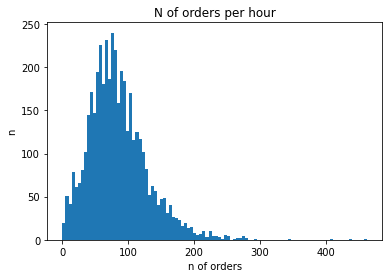

In [8]:
plt.hist(taxi['num_orders'], bins=100)
plt.title('N of orders per hour')
plt.xlabel('n of orders')
plt.ylabel('n')

plt.show()

Let's remove obvious outliers (there are single days when orders exceed 290 — these are difficult to predict, and attracting more drivers won’t be influenced by this; drivers need to be attracted for both 250 and >400 orders). We will also add features: month, date, and day of the week when the order was placed, as well as a moving average.

In [9]:
taxi=taxi[taxi['num_orders'] < 290]

In [10]:
make_features(taxi, 1, 24)

Let's conduct a time series analysis. We'll start by checking the assumption that there is weekly seasonality in the data:

In [11]:
data = taxi.resample('1D').sum()
make_features(data, 1, 7)
data = data['2018-06-01':'2018-06-14']

decomposed_df = decompose_to_df(data)

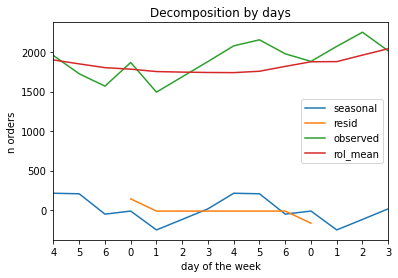

In [12]:
decomposed_df[['seasonal', 'resid', 'observed', 'rol_mean']].plot()
plt.xticks(decomposed_df.index, decomposed_df['dayofweek'])
plt.title('Decomposition by days')
plt.ylabel('n orders')
plt.xlabel('day of the week')
plt.show()

So, we see a clear seasonality by days of the week: the minimum number of orders occurs at the beginning of the week (Monday-Tuesday), while the maximum is at the end of the week. Now, let's check for seasonality by hour:

In [13]:
data = taxi.resample('1H').sum()
make_features(data, 1, 24)
data = data['2018-05-01':'2018-05-07']

decomposed_df = decompose_to_df(data)

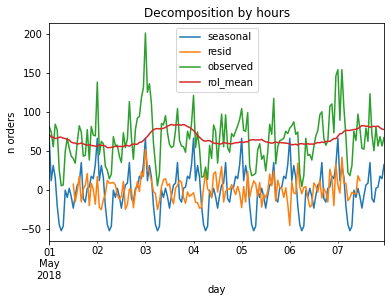

In [14]:
decomposed_df[['seasonal', 'resid', 'observed', 'rol_mean']].plot()
plt.title('Decomposition by hours')
plt.ylabel('n orders')
plt.xlabel('day')
plt.show()

In [15]:
data = taxi.resample('1H').sum()
make_features(data, 1, 24)
data = data['2018-05-01':'2018-05-02']

decomposed_df = decompose_to_df(data)

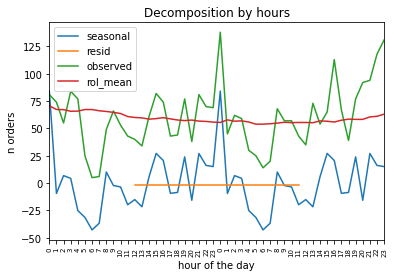

In [16]:
decomposed_df[['seasonal', 'resid', 'observed', 'rol_mean']].plot()
plt.xticks(decomposed_df.index, decomposed_df['hour'], rotation=90, fontsize=7)
plt.title('Decomposition by hours')
plt.ylabel('n orders')
plt.xlabel('hour of the day')
plt.show()

There is also a very clear trend by hour: the peak of orders occurs at midnight, while the minimum is at 6 AM.

Now, let's check how the residuals behave across all data:

In [17]:
data = taxi.resample('1D').sum()
make_features(data, 1, 24)

decomposed_df = decompose_to_df(data)

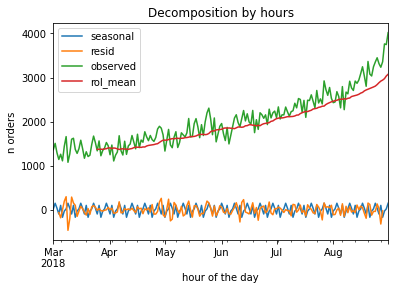

In [18]:
decomposed_df[['seasonal', 'resid', 'observed', 'rol_mean']].plot()
plt.title('Decomposition by hours')
plt.ylabel('n orders')
plt.xlabel('hour of the day')
plt.show()

The residuals remain consistent throughout the entire period.

## Model training

We don't need to encode the features (all are numerical), and there’s no real need to scale them either—how would you scale the day of the week or the month? Therefore, we will directly split the data into training and test sets without shuffling.

In [19]:
train, test = train_test_split(taxi, test_size=.1, shuffle=False)
train = train.dropna()

In [20]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

### Linear regression

In [21]:
model = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search_lr = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')


grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error')

In [22]:
print(f'Best LR score: {np.sqrt(-1*grid_search_lr.best_score_)}')

Best LR score: 31.67854473070821


### Random forest

In [23]:
model = RandomForestRegressor(random_state = 42)

param_grid = {
    'max_depth': [5, 7],
    'n_estimators': [50, 100],
    
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search_rf = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=tscv, 
    verbose=1, 
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 7], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [24]:
print(f'Best RF score: {np.sqrt(-1*grid_search_rf.best_score_)}')

Best RF score: 26.668736350489482


## Testing

Both models performed well (the RMSE metric exceeded the threshold value specified in the task). I chose the random forest for testing, as the RMSE metric for this model was slightly better.

In [25]:
y_pred = grid_search_rf.predict(X_test)

print(f'rmse on test samples for the best estimator: {np.sqrt(mean_squared_error(y_test, y_pred))}')

rmse on test samples for the best estimator: 45.20132611422132


Residual analysis:

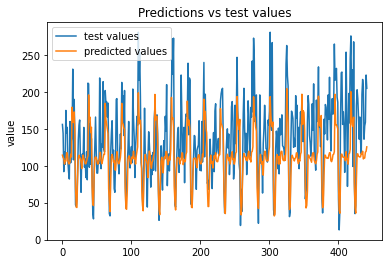

In [26]:
plt.subplots()
plt.plot(y_test.values, label='test values')
plt.plot(y_pred, label='predicted values')
plt.ylabel('value')
plt.title('Predictions vs test values')
plt.legend()
plt.show()

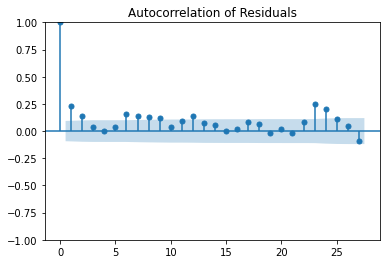

In [27]:
residuals = y_test - y_pred

plot_acf(residuals)
plt.title('Autocorrelation of Residuals')
plt.show()

So, the model starts to predict the number of orders somewhat worse toward the end of the available time series, but overall, the predictions are very accurate. In analyzing the residuals, I didn't notice any peaks on the 1/7-day intervals, which suggests that we accounted for seasonality correctly. However, there is an inexplicable complete absence of peaks at all points that are multiples of 5.

Conclusions:

Resampling the data to an hourly frequency creates a time series optimal for forecasting.

Training the linear regression and random forest models showed that both can be used for predictions; however, the random forest demonstrates a slightly lower RMSE value.

The RMSE of the linear regression model on the test set was less than 48, which meets the requirements specified in the task.

Overall, the model makes very accurate predictions, but it tends to err more as it approaches the end of the time series. This should be considered when deploying the model (it may be necessary to frequently retrain the model if this does not contradict the conditions set by the stakeholders).